In [1]:
import os
root = os.path.join('..', '..')

In [2]:
import sys
sys.path.append(root)

In [3]:

import dataclasses
import os
from typing import Any, Dict, Literal, Optional, Tuple

import torch
from torch import Tensor

from utils.classifiers import OneHiddenNet
from utils.decision_map import (get_axis_vec, get_decision_map,
                                get_inputs_for_decision_map)
from utils.fig import Figure
from utils.utils import freeze, gpu

In [4]:
Figure.set_seaborn_theme()
Figure.set_tex()
Figure.set_high_dpi()
device = gpu(0)
resolution = 800
limit = 3.4

NVIDIA A100-PCIE-40GB


In [5]:
@dataclasses.dataclass
class DataUtil:
    in_dim: int
    hidden_dim: int
    n_sample: int
    n_noise_sample: int
    n_noise_samples: Tuple[int, ...]
    norm: Literal['L0', 'L2', 'Linf']
    mode: Literal['uniform', 'gauss']
    perturbation_constraint: float
    seed: int

    def __post_init__(self) -> None:
        self.d = self._load_data()
    
    def _load_data(self, n_noise_sample: Optional[int] = None) -> Dict[str, Any]:
        n_noise_sample = n_noise_sample if n_noise_sample else self.n_noise_sample
        fname = f'{self.in_dim}_{self.hidden_dim}_{self.n_sample}_{n_noise_sample}' + \
                f'_{self.norm}_{self.mode}_{self.perturbation_constraint}_{self.seed}'
        path = os.path.join(root, 'artificial', fname)
        return torch.load(path, map_location='cpu')
    
    def _define_classifier(self) -> OneHiddenNet:
        classifier = OneHiddenNet(self.in_dim, self.hidden_dim)
        classifier.to(device)

        freeze(classifier)
        classifier.eval()
        
        return classifier

    @torch.no_grad()
    def _get_boundary(
        self, 
        classifier: OneHiddenNet, 
        inputs_for_decision_map: Tensor,
        weight_key: Literal['classifier', 'adv_classifier'],
        n_noise_sample: Optional[int] = None,
    ) -> Tuple[Tensor, Tensor]:
        d = self._load_data(n_noise_sample)
        classifier.load_state_dict(d[weight_key])

        map = get_decision_map(classifier, inputs_for_decision_map)
        
        x_indices = map.argmax(1)
        y = torch.linspace(-limit, limit, resolution)
        x = y[x_indices].flip(0)

        # upsampling
        r = torch.linspace(-limit, limit, 10000)
        y = y[resolution//2] + (y[-10] - y[0]) / (x[-10] - x[0]) * r

        return r, y
    
    @torch.no_grad()
    def _project_natural_input(self, axis_vec_1: Tensor, axis_vec_2: Tensor) -> Tuple[Tensor, Tensor]:
        natural_input = self.d['data']
        s = natural_input.shape
        x = (natural_input * axis_vec_1).expand(s).sum(1)
        y = (natural_input * axis_vec_2).expand(s).sum(1)
        return x, y

    @torch.no_grad()
    def calc(self) -> Any:
        results = []

        classifier = self._define_classifier()

        axis_vec_1, axis_vec_2 = get_axis_vec(self.d['classifier']['linear.weight'])
        
        inputs_for_decision_map = get_inputs_for_decision_map(axis_vec_1, axis_vec_2, resolution, limit)
        inputs_for_decision_map = inputs_for_decision_map.to(device)

        # standard boundary
        std_x, std_y = self._get_boundary(classifier, inputs_for_decision_map, 'classifier')
        results.append([std_x, std_y])

        # perturbation learning boundary
        for n_noise_sample in self.n_noise_samples:
            adv_x, adv_y = self._get_boundary(classifier, inputs_for_decision_map, 'adv_classifier', n_noise_sample)
            results.append([adv_x, adv_y])
            
        # scatter
        s_x, s_y = self._project_natural_input(axis_vec_1, axis_vec_2)
        indices = self.d['labels'] == 1
        results.append([s_x[indices], s_y[indices]])
        results.append([s_x[~indices], s_y[~indices]])

        # Noise map
        classifier.load_state_dict(self.d['noise_classifier'])
        map = get_decision_map(classifier, inputs_for_decision_map)
        results.append(map)

        return results
        

In [6]:
in_dim = 10000
hidden_dim = 1000
n_sample = 1000
n_noise_sample = 100
n_noise_samples = (10, 20, 100)
norm = 'L2'
mode = 'uniform'
perturbation_constraint = 0.78
seed = 5

data_utils = DataUtil(
    in_dim,
    hidden_dim,
    n_sample,
    n_noise_sample,
    n_noise_samples,
    norm,
    mode,
    perturbation_constraint,
    seed,
)

results = data_utils.calc()

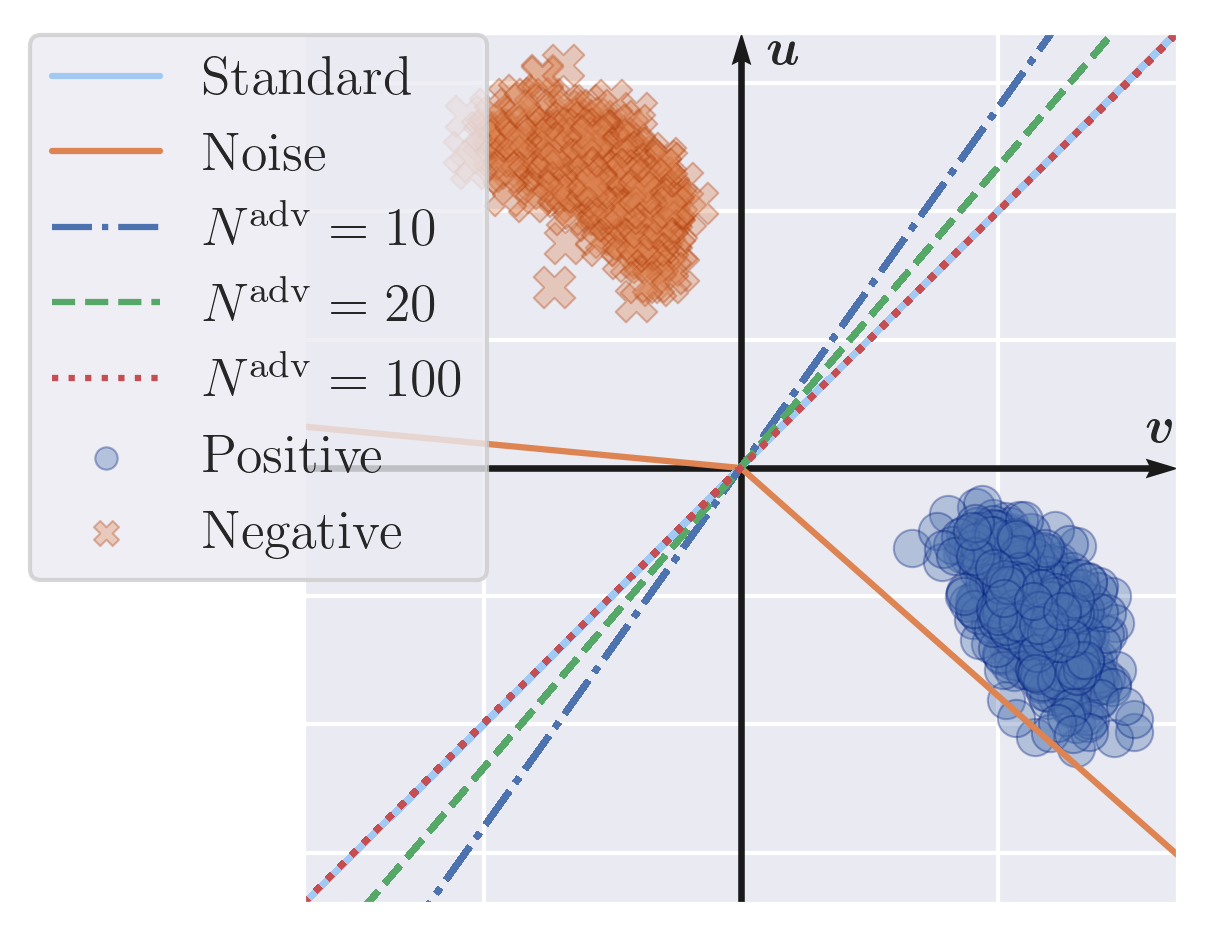

In [7]:
f = Figure(1, 1, (3, 3))
ax = f.axes[0][0]

ax.remove_xticks()
ax.remove_yticks()
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)

std_x, std_y = results[0]
ax.ax.plot(std_x, std_y, color=Figure.light_palette[0], linewidth=1.5, antialiased=False, label='Standard')

map: Tensor = results[6]
y_indices = map.argmax(0)
r = torch.linspace(limit, -limit, resolution)
y = r[y_indices]

r = torch.linspace(-limit, limit, resolution)
x = torch.linspace(-limit, limit, 10000)

y1 = (y[resolution//2 - 10] - y[0]) / (r[resolution//2 - 10] - r[0]) * torch.linspace(-limit, 0, 5000)
y2 = (y[-10] - y[resolution//2+10]) / (r[-10] - r[resolution//2+10]) * torch.linspace(0, limit, 5000)
y = torch.cat([y1, y2])

ax.ax.plot(x, y, color=Figure.palette[1], linewidth=1.5, label='Noise')

for (x, y), n_noise_sample, c, linestyle in zip(results[1:4], n_noise_samples, ('b', 'g', 'r'), ['dashdot', 'dashed', 'dotted']):
    label = r'$N^\mathrm{adv}=' + f'{n_noise_sample}$'
    ax.ax.plot(x, y, color=c, linestyle=linestyle, linewidth=1.5, antialiased=False, label=label)

s_x, s_y = results[4]
ax.ax.scatter(
    s_x, s_y, label='Positive',
    s=80, alpha=0.35, linewidths=0.5, 
    edgecolors=Figure.dark_palette[0], c=[Figure.palette[0]], marker='o', # type: ignore
)

s_x, s_y = results[5]
ax.ax.scatter(
    s_x, s_y, label='Negative',
    s=100, alpha=0.35, linewidths=0.5, 
    edgecolors=Figure.dark_palette[1], c=[Figure.palette[1]], marker='X', # type: ignore
)

ax.horizontal_quiver(limit)
ax.vertical_quiver(limit)

ax.ax.text(limit-0.25, 0.2, r'$\bm{v}$', fontsize=12)
ax.ax.text(0.2, limit-0.25, r'$\bm{u}$', fontsize=12)

f.fig.legend(loc='lower left', bbox_to_anchor=(-0.32, 0.344), ncols=1, frameon=True, fontsize=13, markerscale=0.6)

f.save(root, 'figs', 'decision_map.pdf')
f.show()
f.close()